[<h1>CLICK to SKIP BELOW CODE TO CONTENT</h1>](#Content)

In [12]:
import pandas as pd, numpy as np, os, gc, matplotlib.pyplot as plt, seaborn as sb, re, warnings, calendar, sys
from numpy import arange
get_ipython().run_line_magic('matplotlib', 'inline')
warnings.filterwarnings('ignore'); np.set_printoptions(suppress=True); pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.3f' % x); pd.options.display.max_rows = 15

global directory; directory = '/'

def files(): return os.listdir(directory)

def read_clean(data):
    data.columns = [str(x.lower().strip().replace(' ','_')) for x in data.columns]
    seen = {}; columns = []; i = 0
    for i,x in enumerate(data.columns):
        if x in seen: columns.append(x+'_{}'.format(i))
        else: columns.append(x)
        seen[x] = None
        
    for x in data.columns[data.count()/len(data) < 0.0001]: del data[x];
    gc.collect();
    try: data = data.replace({'':np.nan,' ':np.nan});
    except: pass;
    
    if len(data) < 10000: l = len(data);
    else: l = 10000;
    sample = data.sample(l);size = len(sample);
    
    for x in sample.columns:
        ints = pd.to_numeric(sample[x], downcast = 'integer', errors = 'coerce')
        if ints.count()/size > 0.97:
            minimum = ints.min()
            if minimum > 0: data[x] = pd.to_numeric(data[x], downcast = 'unsigned', errors = 'coerce')
            else: data[x] = pd.to_numeric(data[x], downcast = 'integer', errors = 'coerce')
        else:
            floats = pd.to_numeric(sample[x], downcast = 'float', errors = 'coerce')
            if floats.count()/size > 0.97: data[x] = pd.to_numeric(data[x], downcast = 'float', errors = 'coerce')
            else:
                dates = pd.to_datetime(sample[x], errors = 'coerce')
                if dates.count()/size > 0.97: data[x] = pd.to_datetime(data[x], errors = 'coerce')
    return data.reset_index(drop = True)

def read(x):
    '''Kaggle Reading in CSV files.
    Just type read('file.csv'), and you'll get back a Table.'''
    
    file = '{}/{}'.format(directory,x)
    try:     data = pd.read_csv(file)
    except:  data = pd.read_csv(file, encoding = 'latin-1')
    return read_clean(data)

def tally(column, minimum = 0, top = None, graph = False, percent = False, multiple = False, lowercase = False, min_count = 1):
    '''Provides a tally count of all values in a COLUMN.
        1. minimum  =  (>0)          Least count of item to show.
        2. top      =  (-1,>0)       Only show top N objects
        3. graph    =  (False,True)  Show bar graph of results
        4. percent  =  (False,>0)    Instead of showing counts, show percentages of total count
        
       multiple = False/True.
       If True, counts and tallies objects in list of lists (Count Vectorizer)
       
       lowercase = True / False.
       If True, lowers all text firsrt. So A == a
       
       min_count >= 1
       If a column sum for tag has less than min_count, discard whole column
    '''
    if multiple == False:
        counts = column.value_counts().astype('uint')
        counts = counts[counts >= minimum][:top]
        counts = pd.DataFrame(counts).reset_index()
        counts.columns = [column.name, 'tally']
        if percent: 
            counts['tally'] /= counts['tally'].sum()/100
            counts['tally'] = counts['tally']
        if graph:
            C = counts[::-1]
            C.plot.barh(x = column.name, y = 'tally', legend = False); plt.show();
        return counts
    else:
        from sklearn.feature_extraction.text import CountVectorizer
        column = column.fillna('<NAN>')
        if type(column.iloc[0]) != list: column = column.apply(lambda x: [x])
        counter = CountVectorizer(lowercase = lowercase, tokenizer = lambda x: x, dtype = np.uint32, min_df = min_count)
        counter.fit(column)
        counts = pd.DataFrame(counter.transform(column).toarray())
        counts.columns = [column.name+'_('+str(x)+')' for x in counter.get_feature_names()]
        return counts
    
    
def describe(data):
    '''Provides an overview of your data
        1. dtype    =  Column type
        2. missing% =  % of the column that is missing
        3. nunique  =  Number of unique values in column
        4. top3     =  Top 3 most occuring items
        5. min      =  Minimum value. If not a number column, then empty
        6. mean     =  Average value. If not a number column, then empty
        7. median   =  Middle value. So sort all numbers, and get middle. If not a number column, then empty
        8. max      =  Maximum value. If not a number column, then empty
        9. sample   =  Random 2 elements
        10. name    =  Column Name
    '''
    dtypes = dtype(data)
    length = len(data)
    missing = ((length - data.count())/length*100)
    
    N = [];    most3 = []
    for dt,col in zip(dtypes,data.columns):
        if dt != 'datetime':
            U = data[col].value_counts()
            N.append(len(U))
            if U.values[0] > 1: most3.append(U.index[:3].tolist())
            else: most3.append([]);
        else: N.append(0); most3.append([]);
            
    df = pd.concat([dtypes, missing], 1)
    df.columns = ['dtype','missing%']
    df['nunique'] = N; df['top3'] = most3
    
    numbers = list(data.columns[df['dtype'].isin(('uint','int','float'))])
    df['min'] = data.min()
    df['mean'] = data[numbers].mean()
    df['median'] = data[numbers].median()
    df['max'] = data.max()
    df['sample'] = data.apply(lambda x : x.sample(2).values.tolist())
    df['name'] = list(data.columns)
    return df.sort_values(['missing%', 'nunique', 'dtype'], ascending = [False, False, True]).reset_index(drop = True)


def Checker(x):
    if type(x) is pd.DataFrame: return 0
    elif type(x) is pd.Series: return 1
    else: return -1

def columns(data): return list(data.columns)
def rows(data): return list(data.index)
def index(data): return list(data.index)
def head(data, n = 10): return data.head(n)
def tail(data, n = 10): return data.tail(n)
def sample(data, n = 10): return data.sample(n)

def dtype(data):
    what = Checker(data)
    if what == 0:
        dtypes = data.dtypes.astype('str')
        dtypes = dtypes.str.split(r'\d').str[0]
    else:
        dtypes = str(data.dtypes)
        dtypes = re.split(r'\d', dtypes)[0]
    return dtypes

def mean(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].mean()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.mean()
        else: return np.nan
    else:
        try:     return np.nanmean(data)
        except:  return np.nan
        
def std(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].std()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.std()
        else: return np.nan
    else:
        try:     return np.nanstd(data)
        except:  return np.nan
        
def var(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].var()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.var()
        else: return np.nan
    else:
        try:     return np.nanvar(data)
        except:  return np.nan
        
def log(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        x = np.log(data[numbers])
        x[np.isinf(x)] = np.nan
        return pd.Series(x)
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt:
            x = np.log(data)
            x[np.isinf(x)] = np.nan
            return x
        else: return np.nan
    else:
        try:
            x = np.log(data)
            x[np.isinf(x)] = np.nan
            return x
        except:  return np.nan
        
def median(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].median()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.median()
        else: return np.nan
    else:
        try:     return np.nanmedian(data)
        except:  return np.nan
        
def minimum(data):
    what = Checker(data)
    if what == 0:      return data.min()
    elif what == 1:    return data.min()
    else:              return np.min(data)
        
def maximum(data):
    what = Checker(data)
    if what == 0:      return data.max()
    elif what == 1:    return data.max()
    else:              return np.max(data)
    
def missing(data):
    what = Checker(data)
    if what >= 0:      return pd.isnull(data)
    else:              return np.isnan(data)
    
def count(data):
    what = Checker(data)
    if what >= 0:      return data.count()
    else:              return len(data)
    
def nunique(data):
    what = Checker(data)
    if what >= 0:      return data.nunique()
    else:              return len(np.unique(data))
    
def unique(data):
    if type(data) is pd.DataFrame:
        uniques = []
        for x in data.columns:
            uniques.append(data[x].unique())
        df = pd.Series(uniques)
        df.index = data.columns
        return df
    elif type(data) is pd.Series: return data.unique()
    else:              return np.unique(data)
    
def total(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].sum()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.sum()
        else: return np.nan
    else:
        try:     return np.nansum(data)
        except:  return np.nan
        
def time_number(date): return hours(date)+minutes(date)/60+seconds(date)/60**2
def hours_minutes(date): return hours(date)+minutes(date)/60
def hours(date): return date.dt.hour
def minutes(date): return date.dt.minute
def seconds(date): return date.dt.second
def month(date): return date.dt.month
def year(date): return date.dt.year
def day(date): return date.dt.day
def weekday(date): return date.dt.weekday
def leap_year(date): return year(date).apply(calendar.isleap)
def date_number(date): return year(date)+month(date)/12+day(date)/(365+leap_year(date)*1)
def year_month(date): return year(date)+month(date)/12

def hcat(*columns):
    cols = []
    for c in columns:
        if c is None: continue;
        if type(c) in (list, tuple): 
            for i in c:
                if type(i) not in (pd.DataFrame, pd.Series): cols.append(pd.Series(i))
                else: cols.append(i)
        elif type(c) not in (pd.DataFrame, pd.Series): cols.append(pd.Series(c))
        else: cols.append(c)
    return pd.concat(cols, 1)

def vcat(*columns):
    cols = []
    for c in columns:
        if c is None: continue;
        if type(c) in (list, tuple): 
            for i in c:
                if type(i) not in (pd.DataFrame, pd.Series): cols.append(pd.Series(i))
                else: cols.append(i)
        elif type(c) not in (pd.DataFrame, pd.Series): cols.append(pd.Series(c))
        else: cols.append(c)
    return pd.concat(cols, 0)

def melt(data, columns):
    '''Converts a dataset into long form'''
    return data.melt(id_vars = columns)
    
def tabulate(*columns, method = 'count'):
    '''Splits columns into chunks, and counts the occurences in each group.
        Remember - tabulate works on the LAST column passed.
        Options:
            1. count            = Pure Count in group
            2. count_percent    = Percentage of Count in group
            3. mean             = Mean in group
            4. median           = Median in group
            5. max              = Max in group
            6. min              = Min in group
            7. sum_percent      = Percentage of Sum in group
        Eg:
            Apple | 1
            ---------
            Orange| 3
            ---------
            Apple | 2
            ---------
        Becomes:
            Apple | 1 | 1
            -------------
                  | 2 | 1
            -------------
            Orange| 3 | 1
        
        NOTE --------
            method can be a list of multiple options.
    '''
    if type(method) in (list, tuple):
        xs = []
        for x in method:
            g = tabulate(*columns, method = x)
            xs.append(g)
        xs = hcat(xs)
        xs = xs.T.drop_duplicates().T
        return read_clean(xs)        
    else:
        def percent(series):
            counts = series.count()
            return counts.sum()

        data = hcat(*columns)
        columns = data.columns.tolist()

        if method in ('count', 'count_percent'):
            groups = data.groupby(data.columns.tolist()).apply(lambda x: x[data.columns[-1]].count())

            if method == 'count_percent':
                groups = groups.reset_index()
                groups.columns = list(groups.columns[:-1])+['Group_Count']
                right = data.groupby(columns[:-1]).count().reset_index()
                right.columns = list(right.columns[:-1])+['Group_Sum']

                groups = pd.merge(left = groups, right = right, left_on = columns[:-1], right_on = columns[:-1])
                groups['Percent%'] = groups['Group_Count']/groups['Group_Sum']*100
                groups = groups[columns+['Percent%']]
                return groups

        elif method == 'mean': groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].mean())
        elif method == 'median': groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].median())
        elif method == 'max': groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].max())
        elif method == 'min': groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].min())
        elif method == 'sum_percent':
            groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].sum()).reset_index()
            groups.columns = list(groups.columns[:-1])+['Group_Count']
            right = data.groupby(columns[:-1]).sum().reset_index()
            right.columns = list(right.columns[:-1])+['Group_Sum']

            groups = pd.merge(left = groups, right = right, left_on = columns[:-1], right_on = columns[:-1])
            groups['Sum%'] = groups['Group_Count']/groups['Group_Sum']*100
            groups = groups[cols+['Sum%']]
            return groups
        else:
            print('Method does not exist. Please choose count, count_percent, mean, median, max, min, sum_percent.'); return None;
        #except: print('Method = {}'.format(method)+' cannot work on Object, Non-Numerical data. Choose count.'); return None;

        groups = pd.DataFrame(groups)
        groups.columns = [method]
        groups.reset_index(inplace = True)
        return groups


def sort(data, by = None, how = 'ascending', inplace = False):
    ''' how can be 'ascending' or 'descending' or 'a' or 'd'
    It can also be a list for each sorted column.
    '''
    replacer = {'ascending':True,'a':True,'descending':False,'d':False}
    if by is None and type(data) is pd.Series:
        try:    x = replacer[how]
        except: print("how can be 'ascending' or 'descending' or 'a' or 'd'"); return None;
        return data.sort_values(ascending = x, inplace = inplace)
    elif type(how) is not list:
        try:    how = replacer[how]
        except: print("how can be 'ascending' or 'descending' or 'a' or 'd'"); return None;
    else:
        for x in how: 
            try:    x = replacer[x]
            except: print("how can be 'ascending' or 'descending' or 'a' or 'd'"); return None;
    return data.sort_values(by, ascending = how, inplace = inplace)

def keep(data, what, inplace = False):
    '''Keeps data in a column if it's wanted.
    Everything else is filled with NANs'''
    if type(what) not in (list,tuple,np.array,np.ndarray): what = [what]
    need = data.isin(what)
    if inplace: 
        df = data
        df.loc[~need] = np.nan
    else: 
        df = data.copy()
        df.loc[~need] = np.nan
        return df

def remove(data, what, inplace = False):
    '''Deletes data in a column if it's not wanted.
    Everything else is filled with NANs'''
    if type(what) not in (list,tuple): what = [what]
    need = data.isin(what)
    if inplace: 
        df = data
        df.loc[need] = np.nan
    else: 
        df = data.copy()
        df.loc[need] = np.nan
        return df
    
    
def ternary(data, condition, true, false = np.nan, inplace = False):
    '''C style ternary operator on column.
    Condition executes on column, and if true, is filled with some value.
    If false, then replaced with other value. Default false is NAN.'''
    try:
        execute = 'data {}'.format(condition)
        series = eval(execute)
        try: series = series.map({True:true, False:false})
        except: series = series.replace({True:true, False:false})
        return series
    except: print('Ternary accepts conditions where strings must be enclosed.\nSo == USD not allowed. == "USD" allowed.'); return False;

    
def locate(data, column):
    '''Use ternary to get result and then filter with notnull'''
    if dtype(column) == 'bool': return data.loc[column]
    return data.loc[column.notnull()]
    
    
def query(data, column = None, condition = None):
    '''Querying data based on conditions'''
    if type(column) is str:
        cond = f'data["{column}"]{condition}'
    else:
        cond = f'column{condition}'
    return data.loc[eval(cond)]


def keep_top(x, n = 5):
    '''Keeps top n (after tallying) in a column'''
    df = keep(x, tally(x)[x.name][:n].values)
    return df

def keep_bot(x, n = 5):
    '''Keeps bottom n (after tallying) in a column'''
    df = keep(x, tally(x)[x.name][:-n].values)
    return df


def remove_outlier(x, method = 'iqr', range = 1.5):
    '''Removes outliers in column with methods:
        1. mean     =    meean+range (normally 3.5)
        2. median   =    median+range (normally 3.5)
        3. iqr      =    iqr+range (normally 1.5)
    '''
    i = x.copy()
    if method == 'iqr':
        first = np.nanpercentile(x, 0.25)
        third = np.nanpercentile(x, 0.75)
        iqr = third-first
        i[(i > third+iqr*range) | (i < first-iqr*range)] = np.nan
    else:
        if method == 'mean': mu = np.nanmean(x)
        else: mu = np.nanmedian(x)
        std = np.nanstd(x)
        i[(i > mu+std*range) | (i < mu-std*range)] = np.nan
    return i


def cut(x, bins = 5, method = 'range'):
    '''Cut continuous column into parts.
        Method options:
            1. range
            2. quantile (number of quantile cuts)'''
    if method == 'range': return pd.cut(x, bins = bins, duplicates = 'drop')
    else: return pd.qcut(x, q = bins, duplicates = 'drop')
    
    
def plot(x, y = None, colour = None, column = None, data = None, size = 5, top = 10, wrap = 4, 
         subset = 5000, method = 'mean', quantile = True, bins = 10,
         style = 'lineplot', logx = False, logy = False, logc = False, power = 1):
    '''Plotting function using seaborn and matplotlib
        Options:
        x, y, colour, column, subset, style, method
        
        Plot styles:
            1. boxplot
            2. barplot
            3. tallyplot (counting number of appearances)
            4. violinplot (boxplot just fancier)
            5. lineplot (mean line plot)
            6. histogram
            7. scatterplot (X, Y must be numeric --> dates will be converted)
            8. bivariate (X, Y must be numeric --> dates will be converted)
            9. heatmap (X, Y will be converted into categorical automatically --> bins)
            10. regplot (X, Y must be numeric --> dates will be converted)
    '''
    if type(x) in (np.array,np.ndarray): x = pd.Series(x); x.name = 'x';
    if type(y) in (np.array,np.ndarray): y = pd.Series(y); y.name = 'y';
    if type(column) in (np.array,np.ndarray): column = pd.Series(column); column.name = 'column';
    if type(colour) in (np.array,np.ndarray): colour = pd.Series(colour); colour.name = 'colour';
        
    if type(x) == pd.Series: 
        data = pd.DataFrame(x); x = x.name
        if type(x) is not str:
            data.columns = [str(x)]
            x = str(x)
    if method == 'mean': estimator = np.nanmean
    elif method == 'median': estimator = np.nanmedian
    elif method == 'min': estimator = np.min
    elif method == 'max': estimator = np.max
    else: print('Wrong method. Allowed = mean, median, min, max'); return False;
    #----------------------------------------------------------
    sb.set(rc={'figure.figsize':(size*1.75,size)})
    dtypes = {'x':None,'y':None,'c':None,'col':None}
    names = {'x':None,'y':None,'c':None,'col':None}
    xlim = None
    #----------------------------------------------------------
    if data is not None:
        if type(x) is str: x = data[x];
        if type(y) is str: y = data[y]; 
        if type(colour) is str: colour = data[colour]; 
        if type(column) is str: column = data[column]; 
    if type(x) is str: print('Please specify data.'); return False;
    #----------------------------------------------------------
    if x is not None:
        dtypes['x'] = dtype(x); names['x'] = x.name
        if dtypes['x'] == 'object': x = keep_top(x, n = top)
        elif dtypes['x'] == 'datetime': x = date_number(x)
        if logx and dtype(x) != 'object': x = log(x)
    if y is not None: 
        dtypes['y'] = dtype(y); names['y'] = y.name
        if dtypes['y'] == 'object': y = keep_top(y, n = top)
        elif dtypes['y'] == 'datetime': y = date_number(y)
        if logy and dtype(y) != 'object': y = log(y)
    if colour is not None:
        dtypes['c'] = dtype(colour); names['c'] = colour.name
        if dtypes['c'] == 'object': colour = keep_top(colour, n = top)
        elif dtypes['c'] == 'datetime': colour = date_number(colour)
        if logc and dtype(colour) != 'object': colour = log(colour)
    if column is not None:
        dtypes['col'] = dtype(column); names['col'] = column.name
        if dtypes['col'] == 'object': column = keep_top(column, n = top)
        elif dtypes['col'] == 'datetime': column = date_number(column)
    #----------------------------------------------------------
    df = hcat(x, y, colour, column)
    if subset > len(df): subset = len(df)
    df = sample(df, subset)
    #----------------------------------------------------------
    if column is not None:
        if dtype(df[names['col']]) not in ('object', 'uint',' int') and nunique(df[names['col']]) > top: 
            if quantile: df[names['col']] = cut(df[names['col']], bins = bins, method = 'quantile')
            else: df[names['col']] = cut(df[names['col']], bins = bins, method = 'range')
    
    try: df.sort_values(names['y'], inplace = True);
    except: pass;
    #----------------------------------------------------------
    replace = {'boxplot':'box', 'barplot':'bar', 'tallyplot':'count', 'violinplot':'violin', 
               'lineplot': 'point', 'histogram':'lv'}
    
    if style == 'histogram' and y is None:
        plot = sb.distplot(df[names['x']].loc[df[names['x']].notnull()], bins = bins)
    elif style == 'lineplot' and y is None:
        plot = plt.plot(df[names['x']]);
        plt.show(); return;
    elif style == 'barplot' and y is None:
        plot = df.sort_values(names['x']).plot.bar();
        plt.show(); return;
    elif style in replace.keys():
        if dtype(df[names['x']]) not in ('object', 'uint',' int') and nunique(df[names['x']]) > top: 
            if quantile: df[names['x']] = cut(df[names['x']], bins = bins, method = 'quantile')
            else: df[names['x']] = cut(df[names['x']], bins = bins, method = 'range')
        
        if names['col'] is not None:
            plot = sb.factorplot(x = names['x'], y = names['y'], hue = names['c'], data = df, kind = replace[style], col = names['col'],
                             n_boot = 1, size = size, estimator = estimator, col_wrap = wrap)
        else:
            plot = sb.factorplot(x = names['x'], y = names['y'], hue = names['c'], data = df, kind = replace[style], col = names['col'],
                             n_boot = 1, size = size, estimator = estimator)
            
        for ax in plot.axes.flatten(): 
            for tick in ax.get_xticklabels(): 
                tick.set(rotation=90)
    
    elif style == 'heatmap':
        if dtype(df[names['x']]) != 'object'and nunique(df[names['x']]) > top:
            if quantile: df[names['x']] = cut(df[names['x']], bins = bins, method = 'quantile')
            else: df[names['x']] = cut(df[names['x']], bins = bins, method = 'range')
                
        if dtype(df[names['y']]) != 'object'and nunique(df[names['y']]) > top:
            if quantile: df[names['y']] = cut(df[names['y']], bins = bins, method = 'quantile')
            else: df[names['y']] = cut(df[names['y']], bins = bins, method = 'range')     

        df = tabulate(df[names['x']], df[names['y']]).pivot(index = names['x'], columns = names['y'], values = 'count')
        plot = sb.heatmap(df, cmap="YlGnBu")

        
    elif dtype(df[names['x']]) == 'object' or dtype(df[names['y']]) == 'object':
            print('{} can only take X = number and Y = number.'.format(style)); return False;
        
    elif style  in ('regplot', 'scatterplot'):
        if column is None: col_wrap = None
        else: col_wrap = wrap
        if style == 'regplot': reg = True
        else: reg = False
        
        plot = sb.lmplot(x = names['x'], y = names['y'], hue = names['c'], data = df, col = names['col'],
                             n_boot = 2, size = size, ci = None, scatter_kws={"s": 50,'alpha':0.5},
                        col_wrap = col_wrap, truncate = True, fit_reg = reg, order = power)
        plot.set_xticklabels(rotation=90)
        
    elif style == 'bivariate':
        plot = sb.jointplot(x = names['x'], y = names['y'], data = df, dropna = True, size = size, kind = 'reg',
                           scatter_kws={"s": 50,'alpha':0.5}, space = 0)
    plt.show()
    
def remove(x, what):
    return replace(x, what, '')
    
def notnull(data, loc = None):
    '''Returns the items that are not null in a column / dataframe'''
    if loc is not None:
        return data.loc[loc.notnull()]
    else:
        return data.loc[data.notnull().sum(1) == data.shape[1]]
    
    
def exclude(data, col):
    '''Only returns a dataframe where the columns in col are not included'''
    if type(col) is str: col = [col]
    columns = list(data.columns)
    leave = list(set(columns) - set(col))
    return data[leave]

################### -----------------------------------------------------------------#######################
#Recommendation Systems
def pivot(index, columns, values):
    '''Creates a table where rows = users, columns = items, and cells = values / ratings'''
    from scipy.sparse import dok_matrix
    S = dok_matrix((nunique(index), nunique(columns)), dtype=np.float32)
    
    mins = np.abs(np.min(values))+1
    indexM = {}
    for i,x in enumerate(unique(index)): indexM[x] = i;
    columnsM = {}
    for i,x in enumerate(unique(columns)): columnsM[x] = i;
        
    for i,c,v in zip(index, columns, values+mins): S[indexM[i],columnsM[c]] = v;
    
    S = S.toarray(); S[S == 0] = np.nan; S -= mins
    S = pd.DataFrame(S)
    S.index = indexM.keys(); S.columns = columnsM.keys();
    return S

def row_operation(data, method = 'sum'):
    '''Apply a function to a row
        Allowed functions:
            1. sum
            2. median
            3. mean
            4. max
            5. min
            6. count
            7. count_percent
            8. sum_percent
            9. mean_zero         (Mean but zeroes arent counted)
            10. count_zero       (Count but zeroes arent counted)
        Own functions are also allowed.
    '''
    if method in ('sum','median','mean','max','min','count'):
        x = eval('data.{}(1)'.format(method))
    elif method in ('count_percent', 'sum_percent'):
        x = eval('data.{}(1)'.format(method.split('_')[0]))
        x /= x.sum()
        x *= 100
    elif method in ('mean_zero', 'count_zero'):
        df = data.copy()
        df[df == 0] = np.nan
        x = eval('df.{}(1)'.format(method.split('_')[0]))
    else: return data.apply(method, axis = 1)
    x.name = 'row_operation'
    return x


def col_operation(data, method = 'sum'):
    '''Apply a function to a column
        Allowed functions:
            1. sum
            2. median
            3. mean
            4. max
            5. min
            6. count
            7. count_percent
            8. sum_percent
            9. mean_zero         (Mean but zeroes arent counted)
            10. count_zero       (Count but zeroes arent counted)
        Own functions are also allowed.
        '''
    if method in ('sum','median','mean','max','min','count'):
        x = eval('data.{}(0)'.format(method))
    elif method in ('count_percent', 'sum_percent'):
        x = eval('data.{}(0)'.format(method.split('_')[0]))
        x /= x.sum()
        x *= 100
    elif method in ('mean_zero', 'count_zero'):
        df = data.copy()
        df[df == 0] = np.nan
        x = eval('df.{}(0)'.format(method.split('_')[0]))
    else: return data.apply(method, axis = 0)
    x.name = 'col_operation'
    return x

    
def random(obj, n = 1, p = None):
    if p is not None:
        if type(p) is pd.Series: p = p.values
        if p.sum() > 2: p /= 100
    return list(np.random.choice(obj, size = n, replace = False, p = p))

def row(data, n): return data.loc[n]

def distances(source, target):
    '''Returns all distances between target and source (L2)'''
    Y = np.tile(target.values, (source.shape[0],1))
    nans = np.isnan(Y)
    X = source.values; X[np.isnan(X)] = 0;
    Y[nans] = 0;
    diff = X - Y;
    diff[nans] = 0;
    d = np.linalg.norm(diff, axis = 1)
    j = pd.Series(d)
    j.index = source.index
    return j

<a id='Content'></a>
<h1> 1. Reading Data </h1>

First, check the files in the database:

In [14]:
files()

['.HFS+ Private Directory Data\r',
 'home',
 'usr',
 '.Spotlight-V100',
 'net',
 '.DS_Store',
 '.PKInstallSandboxManager',
 '.PKInstallSandboxManager-SystemSoftware',
 'bin',
 'installer.failurerequests',
 'Network',
 'sbin',
 '.file',
 'etc',
 'var',
 'Library',
 'System',
 '.OSInstallerMessages',
 '.fseventsd',
 'private',
 '.DocumentRevisions-V100',
 '.vol',
 'Users',
 'Applications',
 'opt',
 'dev',
 'Volumes',
 'anaconda3',
 'tmp',
 'cores']

In [95]:
# dir_name = 'goodbooks/'
ratings = pd.read_csv('BX/Ratings.csv')

# import pandas as pd, numpy as np, os, gc, matplotlib.pyplot as plt, re, warnings, calendar, sys
# from numpy import arange
# import codecs
# with codecs.open('goodbooks/BX-Book-Ratings.csv',encoding='utf-8', errors='ignore') as csvfile:
#     ratings = pd.read_csv(csvfile,sep = ';')

Ratings.csv is the list of all ratings of a user / book

In [70]:
ratings = read('ratings.csv')

FileNotFoundError: [Errno 2] File b'//ratings.csv' does not exist: b'//ratings.csv'

In [96]:
head(ratings, 5)

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


Let's see a description of the data using DESCRIBE

In [73]:
describe(ratings)

,dtype,missing%,nunique,top3,min,mean,median,max,sample,name
0,int,0.000,53424,"[12874, 30944, 52036]",1,25616.760,25077.000,53424,"[13047, 5115]",user_id
1,int,0.000,10000,"[2047, 5308, 7358]",1,4943.276,4921.000,10000,"[6235, 4142]",book_id
2,int,0.000,5,"[4, 5, 3]",1,3.857,4.000,5,"[5, 2]",rating


<a id='Plot'></a>
<h1> 2. Plotting and Describing Data </h1>

Let's draw a HISTOGRAM of ratings using PLOT

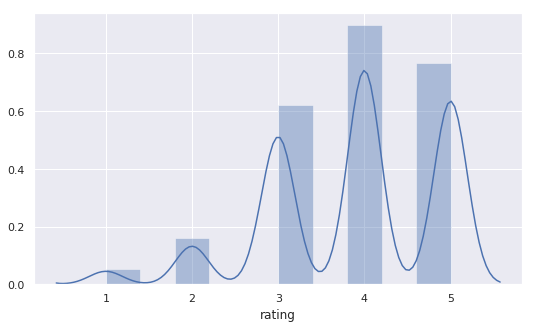

In [74]:
plot(data = ratings, x = 'rating', style = 'histogram')

Clearly, the approximate median / average rating is around 4-5.

Let's see how many books each user reads in a HISTOGRAM.

Use TALLY 

In [75]:
tally(ratings['user_id'])

,user_id,tally
0,12874,200
1,30944,200
2,52036,199
3,28158,199
4,12381,199
5,45554,197
6,6630,197
...,...,...
53417,50389,2
53418,52436,2


In [76]:
head( tally(ratings['user_id']) )

,user_id,tally
0,12874,200
1,30944,200
2,52036,199
3,28158,199
4,12381,199
5,45554,197
6,6630,197
7,37834,197
8,14372,196
9,24143,196


Let's save the # of books into a variable, a plot a HISTOGRAM

In [77]:
user_ratings = tally(ratings['user_id'])
user_ratings = user_ratings['tally']

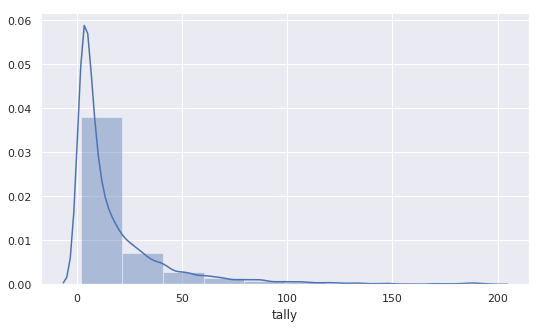

In [78]:
plot(x = user_ratings, style = 'histogram', data = user_ratings)

Now, let's get the AVERAGE RATING per USER!

Let's use TABULATE and METHOD = MEAN

In [79]:
by_user = tabulate(ratings['user_id'], ratings['rating'], method = 'mean')
head(by_user)

,user_id,mean
0,1,3.667
1,2,4.333
2,3,1.000
3,4,4.000
4,5,4.200
5,6,4.500
6,7,3.763
7,8,3.667
8,9,3.143
9,10,3.750


Likewise, let's use a HISTOGRAM to see the per user averages

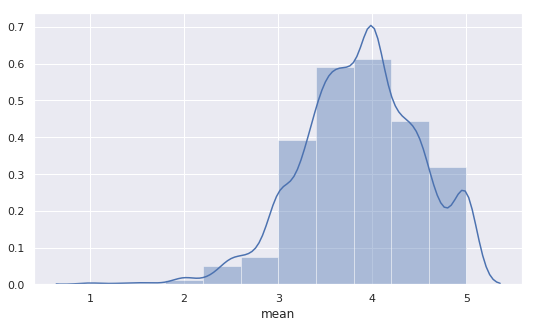

In [80]:
plot(x = 'mean', data = by_user, style = 'histogram')

How about PER BOOK?

In [81]:
by_book = tabulate(ratings['book_id'], ratings['rating'], method = 'mean')
head(by_book)

,book_id,mean
0,1,4.240
1,2,4.210
2,3,3.090
3,4,4.460
4,5,3.890
5,6,4.090
6,7,3.920
7,8,3.830
8,9,3.350
9,10,4.180


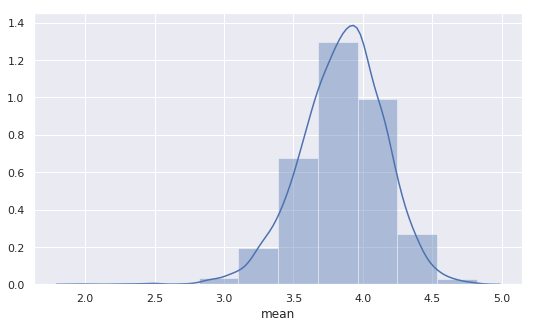

In [82]:
plot(x = 'mean', data = by_book, style = 'histogram')

Let's see which users are the MOST and LEAST readers.

We want to recommend books to the LEAST readers (our goal)

In [83]:
users = tally(ratings['user_id'])
head(users)

,user_id,tally
0,12874,200
1,30944,200
2,52036,199
3,28158,199
4,12381,199
5,45554,197
6,6630,197
7,37834,197
8,14372,196
9,24143,196


<a id='Pivot'></a>
<h1> 3. Pivot Tables in Recommendation Algorithms </h1>

So we have 53,000 users and 10,000 books.

We want to build a large table where rows = each user, columns = each book, and we want this ratings per user table.

Anyways, to make a table rows = each user id, column = each book id, and each cell = rating, use PIVOT

It'll take some time, so be patient.

In [84]:
mappings = pivot(ratings['user_id'], ratings['book_id'], ratings['rating'])

In [85]:
head(mappings)

,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
314,5.000,nan,3.000,nan,4.000,5.000,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
439,3.000,nan,nan,5.000,nan,nan,3.000,nan,3.000,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
588,5.000,nan,1.000,nan,nan,nan,nan,3.000,3.000,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1169,4.000,3.000,nan,5.000,5.000,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1185,4.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2077,4.000,nan,2.000,nan,nan,2.000,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2487,4.000,nan,3.000,5.000,3.000,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2900,5.000,nan,3.000,nan,5.000,nan,nan,3.000,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3662,4.000,nan,4.000,nan,4.000,5.000,nan,nan,nan,4.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3922,5.000,5.000,nan,4.000,2.000,nan,5.000,1.000,3.000,5.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


We can also figure out each user's average rating using ROW_OPERATION.

The HISTOGRAM should look exactly the same as the ones we did before.

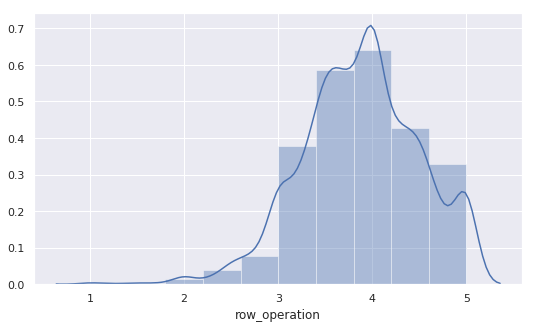

In [86]:
mean_users = row_operation(mappings, 'mean')
plot(mean_users, style = 'histogram')

Likewise, we can also figure out each book's average rating using COL_OPERATION.

The HISTOGRAM should look exactly the same as the ones we did before.

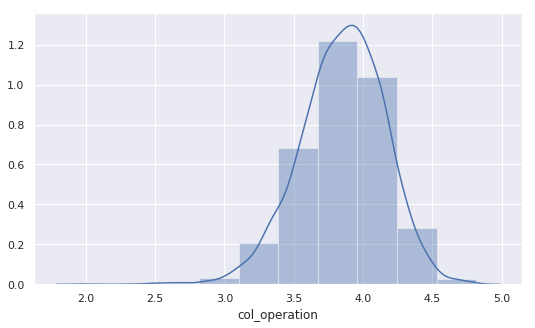

In [87]:
mean_books = col_operation(mappings, 'mean')
plot(mean_books, style = 'histogram')

<a id='Filter'></a>
<h1> 4. COLLOBORATIVE FILTERING </h1>

Let's do some recommendations!

We will be doing 6 major ways of recommendation:

1. Recommending random books

2. Recommending most viewed & most popular --> weighted

3. Recommending "closest user's" books (manual nearest neighbors)

4. Recommending "closest user's" books (nearest neighbors)

**1. Recommending random books**

This is the fastest and cheapest approach (though not accurate and useful)

Literally, when a user comes, check what they haven't read, and recommend a random book.

We firstly want all unique book ids. Use COLUMNS, and then RANDOM to choose a random book.

Each student's random output will be different (since random choosing 1)

In [88]:
random(columns(mappings))

[3683]

We can also choose say 10 random books

In [89]:
random(columns(mappings), 10)

[9971, 5932, 5808, 7014, 486, 6997, 2075, 9350, 4684, 7776]

**2. Recommending most viewed & most popular --> weighted**

Next, we want to recommend books which are the most popular.

So, we want to take the MEAN / AVERAGE of all the COLUMNS (Books).

Let's do that using COL_OPERATION and MEAN.

Note - we also want to COUNT how many ratings each book got - (so get popularity score --> the more people read it - the more popular)

In [90]:
means = col_operation(mappings, 'mean')
counts = col_operation(mappings, 'count')

Let's sort both means, counts by DESCENDING order using SORT, since we want the highest rating and most popular

In [91]:
sorted_means = sort(means, how = 'descending')
head(sorted_means)

7947   4.816
6920   4.778
9566   4.778
5207   4.778
3275   4.770
6361   4.770
5580   4.750
6590   4.750
4483   4.750
1308   4.737
Name: col_operation, dtype: float32

In [92]:
sorted_counts = sort(counts, how = 'descending')
head(sorted_counts)

5000    100
3527    100
3533    100
3532    100
3531    100
3530    100
3529    100
3528    100
3526    100
3561    100
Name: col_operation, dtype: int64

Now, the issue now is sometimes 1 person rated 1 book only with rating = 5. It'll be high on the list.

So, what happens if this happens? If 1 person rates it 5, should be recommend it to new users?

Definitely not! Popularity also matters!

So, we need to combine POPULARITY AND RATINGS into 1 measure.

We will use the rating * LOG(popularity).

Why LOG? It's because the more popular, the better, BUT too large numbers means popularity takes over.

<img src="https://drive.google.com/uc?id=1VE4XOpCi5Qf3uLMzeWVYOPUVyQYhXCMS" style="width: 300px;"/>

In [93]:
score = means*log(counts)
score_sort = sort(score, how = 'descending')
head(score_sort)

3275   21.967
6361   21.967
9566   21.954
5207   21.954
6920   21.954
6590   21.875
5580   21.875
4483   21.875
8978   21.782
3628   21.782
Name: col_operation, dtype: float64

Index means to get actual book.

To get say top 20 books, use 0:20 to index 0 to 20

In [94]:
print(index(score_sort)[0])
print(index(score_sort)[0:20])

3275
[3275, 6361, 9566, 5207, 6920, 6590, 5580, 4483, 8978, 3628, 1308, 3753, 8109, 9141, 2244, 1788, 7947, 4868, 4708, 6642]


**3. Recommending "closest user's" books (manual - nearest neighbors)**

Now, lets MANUALLY recommend books.

What we do, is given a user A, find the CLOSEST user B out of all users U such that we can recommend all the books user B read (the best ones)

Say we get user A, what we essentially do, is find 10 users that are similar, and average all their ratings.

Now, let's find which user has the LEAST read books (we want to recommend books to them.)

Use ROW_OPERATION and COUNT

In [63]:
user_read = row_operation(mappings, 'count')
user_read = sort(user_read, how = 'ascending')

In [64]:
head(user_read)

49960    1
10717    1
6672     1
33596    1
47052    1
20564    1
5099     1
2846     1
27880    1
563      1
Name: row_operation, dtype: int64

Let's get user 563, and the targets are users who have >40 read books.

First, we need to LOCATE all users > 40 books.

In [97]:
over_40 = locate(mappings, user_read > 40)

Now, we want to find the DISTANCE between all users U against user A.

Distance is calculated using the EUCLIDEAN distance or L2 norm. This is the straight line distance between points in any N dimensions.

The shorter the straight line distance, the CLOSER the user.

Below, you can see the straight line EUCLIDEAN distance from A to B

<img src="https://qph.fs.quoracdn.net/main-qimg-e73d01f18d0b4a2f57ff2206a3863c10-c" style="width: 300px;"/>

Remember, let's get user 563 against over_40

Now, the actual process is below: (WHITE means no rating).


<img src="https://drive.google.com/uc?id=1TtaUhOCGKHngpntfmWylDq2m4zVuGrKX" style="width: 500px;"/>

In [98]:
row(mappings, 563)

1       nan
2       nan
3       nan
4       nan
5       nan
6       nan
7       nan
         ..
9994    nan
9995    nan
9996    nan
9997    nan
9998    nan
9999    nan
10000   nan
Name: 563, Length: 10000, dtype: float32

In [99]:
user_563 = row(mappings, 563)
ds = distances(  over_40,  user_563 )

Given the distances, we want to SORT ASCENDING and get maybe the top 1 person with the LEAST distances.

In [100]:
ds = sort(ds, how = 'ascending')
head(ds)

3077    0.000
44794   0.000
28495   0.000
22710   1.000
3174    1.000
25340   1.000
178     1.000
15756   1.000
314     3.000
30027   3.000
dtype: float32

Now, get the top 1 person  in mappings using INDEX and ROW

In [101]:
row(mappings, index(ds)[0])

1       nan
2       nan
3       nan
4       nan
5       nan
6       nan
7       nan
         ..
9994    nan
9995    nan
9996    nan
9997    nan
9998    nan
9999    nan
10000   nan
Name: 3077, Length: 10000, dtype: float32

In [102]:
recommendations = row(mappings, index(ds)[0])
score = sort(recommendations, how = 'descending')

head(score)

1218   5.000
2625   5.000
4558   5.000
3578   5.000
1445   5.000
6009   5.000
1925   4.000
2055   4.000
1907   4.000
3277   4.000
Name: 3077, dtype: float32

So, the best book for user 563 is:

In [103]:
index(score)[0]

1218

Now, select a random user. I'll select user 1000.

(You can change the user number below. HOWEVER - sometimes a user DOESNT exist, so be careful)
<img src="https://static1.squarespace.com/static/5087cbb1e4b0f16d02a0d011/t/53a435e3e4b07e5a2fce9baf/1403270627196/" style="width: 300px;"/>

In [ ]:
#_______________CHANGE USER BELOW_________________________
user = 1000

#Checking______________(DO NOT change below)______________
try: x = row(mappings, user);
except: print('No user exists');
    
ds = distances(over_40, x)
ds = sort(ds, how = 'ascending')
recommendations = row(mappings, index(ds)[0:10])

mean_recommendations = col_operation(recommendations, 'mean')
count_recommendations = col_operation(recommendations, 'count')
log_count_recommendations = log(count_recommendations)

score = mean_recommendations*log_count_recommendations
score = sort(score, how = 'descending')

print(head(score, 10))
print('Recommendations are: {}'.format(index(score)[0:10]))

<a id='Lab'></a>
<h1> 5. Lab Questions </h1>


<img src="https://previews.123rf.com/images/christianchan/christianchan1503/christianchan150300425/37144675--now-it-s-your-turn-note-pinned-on-cork-.jpg" style="width: 300px;"/>

(1) Recommend or get **TOP 30 BEST AVERAGE RATED** books to users.

In [ ]:
average_ratings = col_operation(mappings, 'mean')

In [ ]:
sorted_ratings = sort(average_ratings, how = 'descending')
sorted_ratings[0:30]

(2) Find which **TOP 100** books have the highest **average rating**. Then, recommend from those top 100 **ANY 30 RANDOM books**.

In [ ]:
top_100 = sorted_ratings[0:100]
random(top_100.index, 30)

Once you are done, and satisfied with your work, let the tutor mark you.

Note, if you can't get it, it's fine. Marks are awarded for trying the questions out. We don't mind if the output is wrong.

<h2>ASSIGNMENT 1 (week 3 to 5) 7 marks</h2>

This night (Friday Week 3), you will receive a Kaggle link to **Assignment 1**. It's worth 7 marks, and super easy :).

The stuff you learnt in week 1, 2 and today will be enough to complete Assignment 1 entirely.

It's due in 2 weeks time on Saturday week 5 10pm. We need you to submit a URL / LINK to your assignment notebook on Kaggle.

IT MUST BE **PUBLIC**. Also, download the Kaggle file, and upload it to Moodle by 10pm Saturday week 5.

<h2>TABLEAU</h2>

Next week, we will be using **TABLEAU**. Please download it. If you have trouble, please ask us.